In [1]:
from pathlib import Path
import numpy as np
from PIL import Image
from sklearn.datasets import fetch_lfw_people

# Download LFW (color RGB). This will fetch to your sklearn data dir.
lfw = fetch_lfw_people(color=True, resize=1.0, funneled=True, download_if_missing=True)

data_root = Path("data_lfw")
data_root.mkdir(exist_ok=True)
print('file generated!')
# Map target index -> name for quick lookup
names = lfw.target_names

# Write images to class-per-person folders
for idx, (img, target) in enumerate(zip(lfw.images, lfw.target)):
    person = names[target]
    out_dir = data_root / person
    out_dir.mkdir(parents=True, exist_ok=True)
    # lfw.images is float in [0, 255]; ensure uint8 RGB
    arr = np.clip(255*img, 0, 255).astype(np.uint8)
    out_path = out_dir / f"{idx:06d}.jpg"
    Image.fromarray(arr).save(out_path)

print("Saved LFW to", data_root, "with", len(list(data_root.rglob('*.jpg'))), "images")


file generated!
Saved LFW to data_lfw with 13233 images


In [11]:
import sys
from pathlib import Path
import torch

# Ensure repo src/ is importable
ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.dataset import FaceDataset

ds = FaceDataset(
    root="data_lfw",
    img_size=112,
    use_heatmaps=True,
    extractor="dlib",   # or "dlib" if you installed it
    cache_heatmaps=False,
    cache_landmarks=False,
    add_mask_channel=True,
    hflip_p=0.0,             # deterministic for inspection
    group_all_landmarks=False
)

print("Dataset size:", len(ds), "classes:", len(ds.dataset.classes))
x, y, meta = ds[0]
print("Single sample shape:", x.shape, "label:", y, "meta.ok:", meta["ok"])

loader = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=False)
xb, yb, mb = next(iter(loader))
print("Batch shape:", xb.shape)  # expect (B, 3 + 6 + 1, 112, 112) when heatmaps+mask enabled

Dataset size: 12 classes: 12
Single sample shape: torch.Size([10, 112, 112]) label: 0 meta.ok: True
Batch shape: torch.Size([4, 10, 112, 112])


In [12]:
x.shape

torch.Size([10, 112, 112])

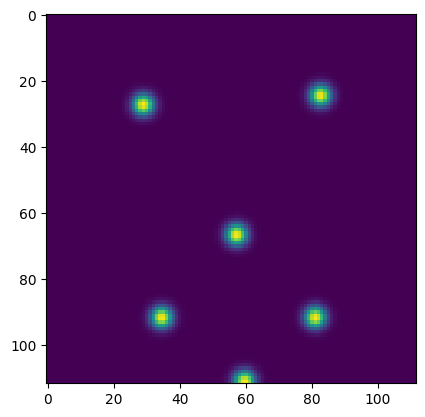

In [13]:
import matplotlib.pyplot as plt
plt.imshow(x[3:,:,:].mean(0))

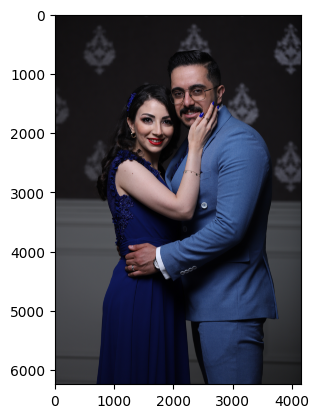

In [ ]:
img  = cv2.imread('/Users/alirezaghadimi/Documents/Projects/MASc CS York/Fall 2025/Computer Vision/FaceRec/IMG_6719.JPG')
plt.imshow(img[:,:,::-1])

In [130]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

True

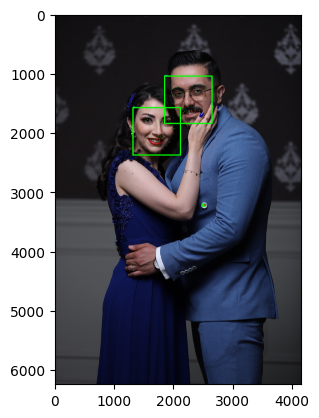

In [137]:
import os, cv2
import dlib
import dlib, cv2

img = cv2.imread("IMG_6719.JPG")  # BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
detector = dlib.get_frontal_face_detector()
rects = detector(cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2GRAY), 1)

for fid, rect in enumerate(rects, start=1):
    x1, y1, x2, y2 = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 20)
        # Draw landmarks
    shape = predictor(img, rect)  # dlib.full_object_detection
    pts = np.array([(shape.part(i).x, shape.part(i).y) for i in range(shape.num_parts)],
                    dtype=np.int32)  # (68, 2)
    for i, (x, y) in enumerate(pts, start=1):
        cv2.circle(img, (int(x), int(y)), 3, (0, 255, 0), 2)
        if True:
            cv2.putText(img, str(i), (int(x)+2, int(y)-2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 0, 0), 1, cv2.LINE_AA)

    # Optional: label the face id
    cv2.putText(img, f"Face {fid}", (rect.left(), max(0, rect.top()-8)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2, cv2.LINE_AA)
plt.imshow(img)
cv2.imwrite('faces_with_boxes.jpg', img[:,:,::-1])



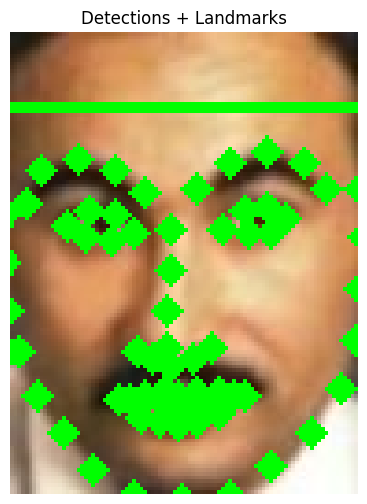

In [165]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# --- Paths ---
IMG_PATH = "/Users/alirezaghadimi/Documents/Projects/MASc CS York/Fall 2025/Computer Vision/FaceRec/data_lfw/Mamdouh Habib/000009.jpg"
# IMG_PATH = "IMG_6719.JPG"

PRED_PATH = "shape_predictor_68_face_landmarks.dat"

# --- Load ---
img_bgr = cv2.imread(IMG_PATH)
assert img_bgr is not None, f"Could not read {IMG_PATH}"
H, W = img_bgr.shape[:2]

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector  = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PRED_PATH)

# Detect (upsample=1 is a good start)
rects = detector(img_rgb, 1)

all_pts = []
for fid, rect in enumerate(rects, start=1):
    # Draw box (on BGR so we can save easily)
    cv2.rectangle(img_bgr, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)

    # Landmarks on the SAME image array used for detection
    shape = predictor(img_rgb, rect)
    pts = np.array([(shape.part(i).x, shape.part(i).y) for i in range(shape.num_parts)], dtype=np.float32)  # (68,2)
    all_pts.append(pts)

    # Draw landmarks
    for i, (x, y) in enumerate(pts, start=1):
        cv2.circle(img_bgr, (int(x), int(y)), 2, (0, 255, 0), 4)


# --- Build heatmaps for the first face (extend as needed) ---
if len(all_pts) > 0:
    pts68 = all_pts[0]  # take face 0
    sigma_px = _sigma_from_img((H, W), frac=0.02, clip=(2.0, 4.0))

    # Option A: per-point (68 channels)
    hm_pts = rasterize_gaussians(pts68, H, W, sigma_px)  # (68,H,W)

    # Option B: grouped (6 channels)
    hm_grp, group_names = make_grouped_heatmaps(pts68, H, W, sigma_px)  # (6,H,W), names list

    # Visualize one grouped heatmap overlay (e.g., left eye)
    overlay = img_bgr.copy()
    hm_vis = (hm_grp[0] * 255).astype(np.uint8)  # choose channel 0 (eye_L)
    hm_vis_color = cv2.applyColorMap(hm_vis, cv2.COLORMAP_JET)
    alpha = 0.45
    overlay = cv2.addWeighted(hm_vis_color, alpha, overlay, 1 - alpha, 0)

    cv2.imwrite("landmarks_overlay.jpg", overlay)

    # Save numpy arrays if you want to feed a model later
    np.save("heatmaps_68.npy", hm_pts.astype(np.float32))   # (68,H,W)
    np.save("heatmaps_grouped.npy", hm_grp.astype(np.float32))  # (6,H,W)

# Save landmarks visualization
cv2.imwrite("faces_with_boxes.jpg", img_bgr)

# Quick matplotlib preview
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title("Detections + Landmarks")
plt.axis('off')
plt.show()


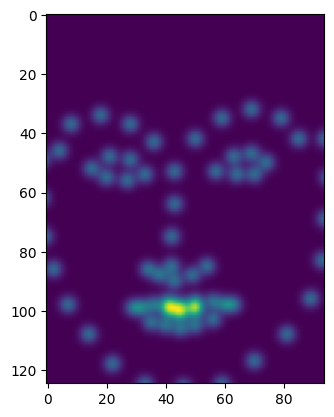

In [174]:
pts68 = all_pts[0]  # take face 0
sigma_px = _sigma_from_img((H, W), frac=0.02, clip=(2.0, 4.0))

# Option A: per-point (68 channels)
hm_pts = rasterize_gaussians(pts68, H, W, sigma_px)

# plt.figure(figsize=(30,20))
plt.imshow(hm_pts.sum(0))

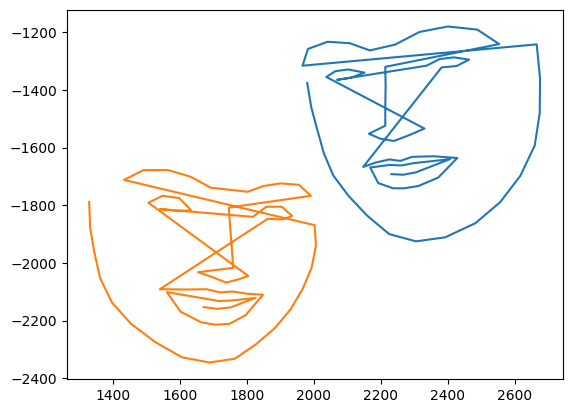

In [154]:
plt.plot(all_pts[0][:,0],-all_pts[0][:,1])
plt.plot(all_pts[1][:,0],-all_pts[1][:,1])
# plt.plot(all_pts[2][:,0],-all_pts[2][:,1])


In [139]:
import numpy as np
import cv2

def _sigma_from_img(hw, frac=0.02, clip=(2.0, 4.0)):
    """Choose sigma in pixels based on image size."""
    s = frac * min(hw)
    return float(np.clip(s, clip[0], clip[1]))

def rasterize_gaussians(points_xy, H, W, sigma_px):
    """
    Per-point heatmaps.
    points_xy: (N, 2) array of (x, y) in pixel coords
    returns heatmaps: (N, H, W) in [0,1]
    """
    if len(points_xy) == 0:
        return np.zeros((0, H, W), dtype=np.float32)

    # Meshgrid once
    ys = np.arange(H, dtype=np.float32)[:, None]  # (H,1)
    xs = np.arange(W, dtype=np.float32)[None, :]  # (1,W)
    xs2 = np.broadcast_to(xs, (H, W))
    ys2 = np.broadcast_to(ys, (H, W))

    heatmaps = np.zeros((len(points_xy), H, W), dtype=np.float32)
    inv_2s2 = 1.0 / (2.0 * (sigma_px ** 2) + 1e-8)

    for i, (x0, y0) in enumerate(points_xy):
        # robust to out-of-frame coords
        dx2 = (xs2 - float(x0)) ** 2
        dy2 = (ys2 - float(y0)) ** 2
        heatmaps[i] = np.exp(-(dx2 + dy2) * inv_2s2)

    return heatmaps

# --- Grouped heatmaps (for dlib-68) ---
DLIB68_GROUPS = {
    "eye_L":   list(range(36, 42)),  # 36..41
    "eye_R":   list(range(42, 48)),  # 42..47
    "nose":    [30],                 # nose tip
    "mouth_L": [48],
    "mouth_R": [54],
    "chin":    [8],
}

def make_grouped_heatmaps(pts68_xy, H, W, sigma_px, groups=DLIB68_GROUPS):
    """
    pts68_xy: (68,2) array of (x,y)
    returns: (C,H,W) with C=len(groups)
    """
    centers = []
    names   = []
    for gname, idxs in groups.items():
        sub = np.asarray([pts68_xy[i] for i in idxs if 0 <= i < len(pts68_xy)], dtype=np.float32)
        if sub.size == 0:
            # fallback center outside image (will become near-zero)
            centers.append(np.array([-9999.0, -9999.0], dtype=np.float32))
        else:
            # mouth corners keep specific points; others use centroid
            if gname in ("mouth_L", "mouth_R", "nose", "chin"):
                centers.append(sub.mean(axis=0))  # nose/chin single idx still okay
            else:
                centers.append(sub.mean(axis=0))
        names.append(gname)

    centers = np.vstack(centers)  # (C,2)
    HMs = rasterize_gaussians(centers, H, W, sigma_px)  # (C,H,W)
    return HMs, names


Text(0.5, 1.0, 'Barbara Bodine')

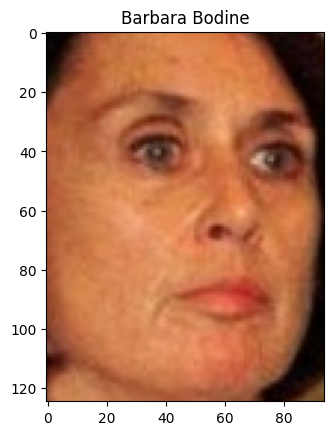

In [175]:
plt.imshow(arr)
plt.title(person)

In [189]:
import sys
from pathlib import Path
import torch

# Ensure repo src/ is importable
ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.dataset import FaceDataset

ds = FaceDataset(
    root="data_lfw",
    img_size=112,
    use_heatmaps=True,
    extractor="dlib",   # or "dlib" if you installed it
    cache_heatmaps=False,
    cache_landmarks=False,
    add_mask_channel=True,
    hflip_p=0.0,             # deterministic for inspection
)

print("Dataset size:", len(ds), "classes:", len(ds.dataset.classes))
x, y, meta = ds[0]
print("Single sample shape:", x.shape, "label:", y, "meta.ok:", meta["ok"])

loader = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=False)
xb, yb, mb = next(iter(loader))
print("Batch shape:", xb.shape)  # expect (B, 3 + 6 + 1, 112, 112) when heatmaps+mask enabled


Dataset size: 12 classes: 12
Single sample shape: torch.Size([10, 112, 112]) label: 0 meta.ok: False
Batch shape: torch.Size([4, 10, 112, 112])


tensor(0.)

In [92]:
import os, cv2
import dlib
path = os.environ.get("DLIB_LANDMARK_MODEL")
print("Predictor path:", path, "exists:", os.path.exists(path) if path else False)
detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(path)  # will throw if missing
# img = cv2.imread("some_face.jpg", cv2.IMREAD_GRAYSCALE)
dets = detector(arr, 1)
print("Detections:", len(dets))
# if dets:
#     shape = predictor(img, dets[0])
#     print("Landmarks:", len(shape.parts()))


Predictor path: None exists: False
Detections: 1


NameError: name 'cv' is not defined

In [111]:
import dlib
dlib_detector = dlib.get_frontal_face_detector()

print(dlib_detector(arr,1))

# def extract_dlib(self, image_bgr: np.ndarray) -> Tuple[np.ndarray, bool]:
#     gray = image_bgr[:, :, 0] if image_bgr.ndim == 3 else image_bgr
#     dets = self._dlib_detector(gray, 1)
#     if len(dets) == 0:
#         return self._dummy_landmarks(image_bgr.shape[:2])
#     shape = self._dlib_predictor(gray, dets[0])
#     points = np.array([[p.x, p.y] for p in shape.parts()], dtype=np.float32)
#     return points, True

rectangles[[(-14, 17) (86, 106)]]


torch.Size([10, 112, 112])


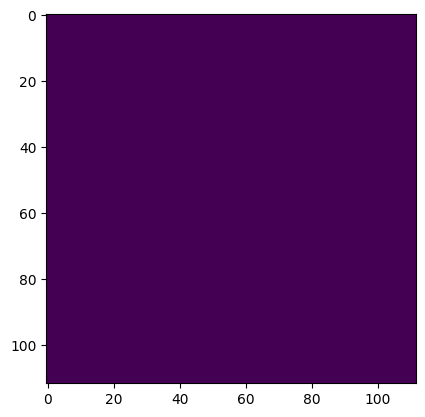

In [ ]:
print(x.shape)
# plt.imshow(x[3:,:,:].mean(axis=0))
plt.imshow(x[4,:,:])

In [1]:
# If running from the repo root, adjust as needed
import sys, tempfile, shutil
from pathlib import Path
import numpy as np
from PIL import Image
import torch

# Make sure src/ is importable
ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.dataset import FaceDataset

# Create a tiny dummy ImageFolder dataset
tmp = tempfile.mkdtemp()
try:
    for cls in ["alice", "bob"]:
        (Path(tmp) / cls).mkdir(parents=True, exist_ok=True)
        for i in range(2):
            arr = (np.random.rand(128, 128, 3) * 255).astype("uint8")
            Image.fromarray(arr).save(Path(tmp) / cls / f"{i}.jpg")

    ds = FaceDataset(
        root=tmp,
        img_size=112,
        use_heatmaps=True,
        extractor="mediapipe",  # or "dlib" if installed
        cache_heatmaps=False,
        cache_landmarks=False,
        add_mask_channel=True,
        hflip_p=0.0,  # deterministic for the test
    )

    # Pull one sample
    x, y, meta = ds[0]
    print("Sample shape:", x.shape)  # expect (3+6+1, 112, 112)
    print("Label:", y, "Meta:", meta)

    # Or iterate a batch
    loader = torch.utils.data.DataLoader(ds, batch_size=2, shuffle=False)
    xb, yb, mb = next(iter(loader))
    print("Batch shape:", xb.shape)  # expect (2, 10, 112, 112)
finally:
    shutil.rmtree(tmp)


Sample shape: torch.Size([10, 112, 112])
Label: 0 Meta: {'path': '/var/folders/jh/jkzk628x73bbvb36b8fg8lgm0000gn/T/tmpeb6ofmpz/alice/0.jpg', 'ok': False}
Batch shape: torch.Size([2, 10, 112, 112])


I0000 00:00:1764265850.832298  229167 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764265850.834339  229350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764265850.838678  229350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764265850.840261  229350 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


NameError: name 'img' is not defined

In [3]:
import cv2
img = cv2.imread('/Users/alirezaghadimi/Documents/Projects/MASc CS York/Fall 2025/Computer Vision/FaceRec/data_vggface2/1350/000002.jpg')
img.shape

(191, 167, 3)

In [5]:
pwd

'/Users/alirezaghadimi/Documents/Projects/MASc CS York/Fall 2025/Computer Vision/FaceRec'

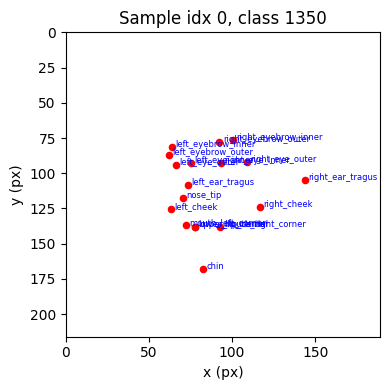

In [13]:
import csv
from pathlib import Path
csv_path  = r'/Users/alirezaghadimi/Documents/Projects/MASc CS York/Fall 2025/Computer Vision/FaceRec/data_vggface2/dataset.csv'
csv_path = Path(csv_path)  # adjust to your path
row_idx = 0 
with csv_path.open("r", encoding="utf-8") as f:
    reader = csv.reader(f)
    header = next(reader)
    rows = list(reader)

row = rows[row_idx]
h, w = float(row[2]), float(row[3])
coords = np.array(row[4:], dtype=float).reshape(-1, 2)

names = []
for i in range(4, len(header), 2):
    names.append(header[i].replace("_x", ""))

plt.figure(figsize=(4, 4))
for (x, y), name in zip(coords, names):
    if x < 0 or y < 0:
        continue
    plt.scatter(x, y, s=20, c="red")
    plt.text(x + 2, y, name, fontsize=6, color="blue")

plt.xlim(0, w)
plt.ylim(h, 0)  # invert y to match image coordinate system
plt.title(f"Sample idx {row_idx}, class {row[1]}")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.tight_layout()
plt.show()

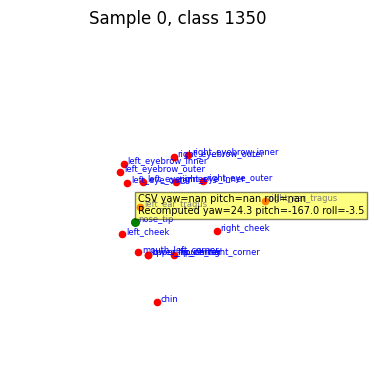

In [14]:
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from src.headpose import estimate_head_pose

csv_path = Path("data_vggface2_landmarks.csv")  # adjust
row_idx = 0  # choose a row to inspect

with csv_path.open("r", encoding="utf-8") as f:
    reader = csv.reader(f)
    header = next(reader)
    rows = list(reader)

row = rows[row_idx]
h, w = float(row[2]), float(row[3])
coords = np.array(row[4:-3], dtype=float).reshape(-1, 2)
yaw_csv, pitch_csv, roll_csv = map(float, row[-3:])

# Recompute pose from landmarks (uses the subset ordering)
yaw_est, pitch_est, roll_est = estimate_head_pose(coords, (h, w), mode="mediapipe")

names = []
for i in range(4, len(header) - 3, 2):
    names.append(header[i].replace("_x", ""))

# Nose index in the subset list defined in build_vggface2
NOSE_IDX = names.index("nose_tip")
nose_x, nose_y = coords[NOSE_IDX]

plt.figure(figsize=(4, 4))
for (x, y), name in zip(coords, names):
    if x < 0 or y < 0:
        continue
    plt.scatter(x, y, s=20, c="red")
    plt.text(x + 2, y, name, fontsize=6, color="blue")

plt.scatter(nose_x, nose_y, s=30, c="green", label="nose (origin)")
plt.text(nose_x + 2, nose_y - 5,
         f"CSV yaw={yaw_csv:.1f} pitch={pitch_csv:.1f} roll={roll_csv:.1f}\n"
         f"Recomputed yaw={yaw_est:.1f} pitch={pitch_est:.1f} roll={roll_est:.1f}",
         color="black", fontsize=7, bbox=dict(facecolor="yellow", alpha=0.5, pad=2))

plt.xlim(0, w); plt.ylim(h, 0)
plt.title(f"Sample {row_idx}, class {row[1]}")
plt.axis("off")
plt.tight_layout()
plt.show()


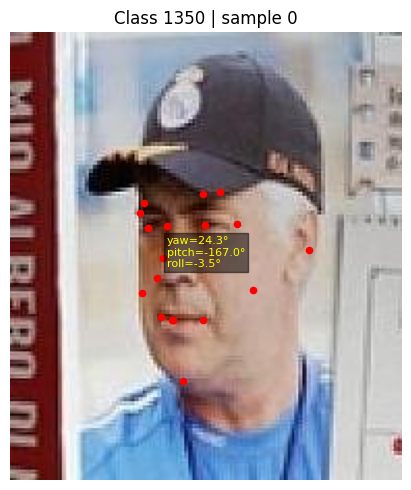

In [15]:
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

csv_path = Path("data_vggface2_landmarks.csv")  # adjust
image_root = Path("data_vggface2")              # adjust
row_idx = 0                                     # pick a sample

# Load CSV
with csv_path.open("r", encoding="utf-8") as f:
    reader = csv.reader(f)
    header = next(reader)
    rows = list(reader)

row = rows[row_idx]
class_id = str(row[1])
h, w = float(row[2]), float(row[3])
coords = np.array(row[4:-3], dtype=float).reshape(-1, 2)
yaw, pitch, roll = map(float, row[-3:])

# Reconstruct landmark names from header
names = []
for i in range(4, len(header) - 3, 2):
    names.append(header[i].replace("_x", ""))

# Nose index (matches subset defined in build_vggface2.py)
NOSE_NAME = "nose_tip"
nose_idx = names.index(NOSE_NAME)
nose_x, nose_y = coords[nose_idx]

# Pick an image from this class (first one)
img_files = sorted((image_root / class_id).glob("*.jpg"))
if not img_files:
    raise FileNotFoundError(f"No images for class {class_id}")
img = Image.open(img_files[0]).convert("RGB")

plt.figure(figsize=(5, 5))
plt.imshow(img)
# Draw landmarks
for (x, y), name in zip(coords, names):
    if x < 0 or y < 0:
        continue
    plt.scatter(x, y, s=20, c="red")
# Pose text at nose
plt.text(
    nose_x + 5, nose_y - 5,
    f"yaw={yaw:.1f}°\npitch={pitch:.1f}°\nroll={roll:.1f}°",
    color="yellow", fontsize=8,
    bbox=dict(facecolor="black", alpha=0.5, pad=2),
)
plt.title(f"Class {class_id} | sample {row_idx}")
plt.axis("off")
plt.tight_layout()
plt.show()


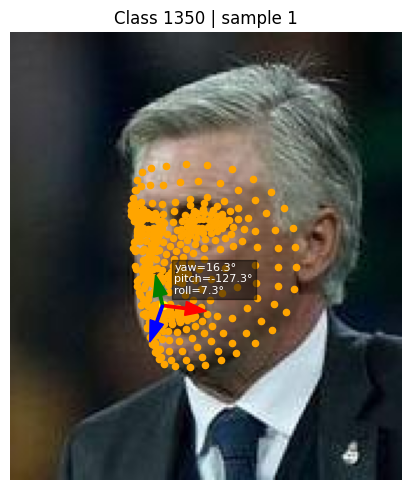

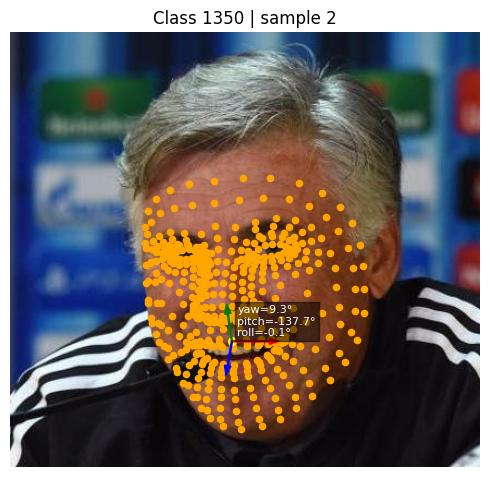

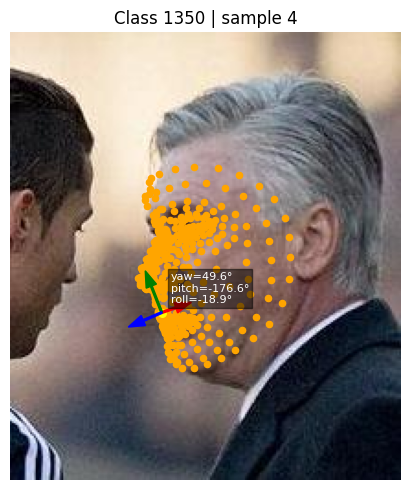

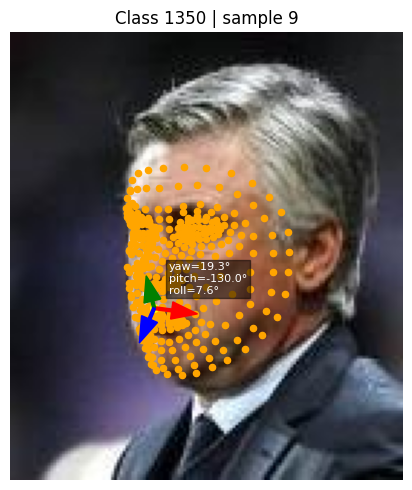

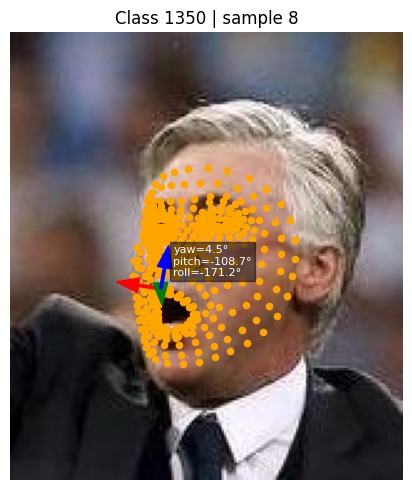

In [29]:
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

csv_path = Path("data_vggface2_landmarks.csv")  # adjust
image_root = Path("data_vggface2")              # adjust
row_idx = 12                                     # pick a sample

# Load CSV
with csv_path.open("r", encoding="utf-8") as f:
    reader = csv.reader(f)
    header = next(reader)
    rows = list(reader)

for row_idx in [1,2,4,9,8]:
    row = rows[row_idx]
    class_id = str(row[1])
    h, w = float(row[2]), float(row[3])
    coords = np.array(row[4:-3], dtype=float).reshape(-1, 2)
    yaw_deg, pitch_deg, roll_deg = map(float, row[-3:])

    # Reconstruct landmark names and nose location
    names = [header[i].replace("_x", "") for i in range(4, len(header) - 3, 2)]
    nose_idx = names.index("lm_0")
    nose_x, nose_y = coords[nose_idx]

    # Pick an image from this class
    img_files = sorted((image_root / class_id).glob("*.jpg"))
    if not img_files:
        raise FileNotFoundError(f"No images for class {class_id}")
    img = Image.open(img_files[row_idx]).convert("RGB")

    # Rotation matrix from yaw/pitch/roll (yaw about Y, pitch about X, roll about Z)
    if np.isnan([yaw_deg, pitch_deg, roll_deg]).any():
        raise ValueError("Pose is NaN; ensure landmarks were detected.")
    yaw, pitch, roll = np.radians([yaw_deg, pitch_deg, roll_deg])
    Ry = np.array([[ math.cos(yaw), 0, math.sin(yaw)],
                [ 0,             1, 0            ],
                [-math.sin(yaw), 0, math.cos(yaw)]])
    Rx = np.array([[1, 0,              0             ],
                [0, math.cos(pitch),-math.sin(pitch)],
                [0, math.sin(pitch), math.cos(pitch)]])
    Rz = np.array([[math.cos(roll), -math.sin(roll), 0],
                [math.sin(roll),  math.cos(roll), 0],
                [0,               0,              1]])
    R = Rz @ Ry @ Rx

    # Define axes in 3D and project to image plane (pinhole, origin at nose)
    axes = {
        "X": (np.array([50, 0, 0], dtype=float), "red"),
        "Y": (np.array([0, 50, 0], dtype=float), "green"),
        "Z": (np.array([0, 0, 50], dtype=float), "blue"),
    }
    f = max(h, w)  # simple focal length guess
    origin_3d = np.array([0, 0, 500.0], dtype=float)  # keep Z positive
    proj_pts = {}
    for name, (vec, color) in axes.items():
        pt3d = R @ vec + origin_3d
        x2d = f * (pt3d[0] / pt3d[2]) + nose_x
        y2d = f * (pt3d[1] / pt3d[2]) + nose_y
        proj_pts[name] = (x2d, y2d, color)

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    for (x, y), nm in zip(coords, names):
        if x < 0 or y < 0:
            continue
        plt.scatter(x, y, s=20, c="orange")
    plt.scatter(nose_x, nose_y, s=30, c="yellow", label="nose")
    for name, (x2d, y2d, color) in proj_pts.items():
        plt.arrow(nose_x, nose_y, x2d - nose_x, y2d - nose_y,
                color=color, width=1.0, head_width=6, length_includes_head=True,
                label=name)
    plt.text(nose_x + 5, nose_y - 5,
            f"yaw={yaw_deg:.1f}°\npitch={pitch_deg:.1f}°\nroll={roll_deg:.1f}°",
            color="white", fontsize=8, bbox=dict(facecolor="black", alpha=0.5, pad=2))
    plt.title(f"Class {class_id} | sample {row_idx}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

